In [ ]:
# Use the entire width of the screen if needed
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

---

Here is a good resource explaining the details of choosing t and C for the Hamiltonian Simulation and the controlled rotation respectively.

https://quantumcomputing.com/strangeworks/harrow-hassidim-lloyd-hhl-algorithm

---

In [317]:
# Reset the kernel if needed

%reset -f

In [318]:
# import the relevant libraries etc.
# set up the environment

from qiskit import *
import numpy as np


%matplotlib inline



In [319]:
# Define the problem (the tridiagonal matrix that we are interested in solving)

a = 1
b = 1/2

# Problem size
n_w = 6
N_w = 2**n_w

In [320]:
# make the tridiagonal matrix in classical form
classical_matrix = np.zeros((N_w,N_w))
for _i in range(N_w):
    for _j in range(N_w):
        if _i==_j:
            classical_matrix[_i,_j]=a
        if abs(_i-_j)==1:
            classical_matrix[_i,_j]=b

In [321]:
print(classical_matrix)

[[1.  0.5 0.  ... 0.  0.  0. ]
 [0.5 1.  0.5 ... 0.  0.  0. ]
 [0.  0.5 1.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 1.  0.5 0. ]
 [0.  0.  0.  ... 0.5 1.  0.5]
 [0.  0.  0.  ... 0.  0.5 1. ]]


In [344]:
eigenvalues = np.linalg.eigvals(classical_matrix)

In [345]:
print('maximum: {}\nminimum: {}\nkappa: {}'.format(np.max(eigenvalues),np.min(eigenvalues),np.max(eigenvalues)/np.min(eigenvalues)))

maximum: 1.998832226832324
minimum: 0.0011677731676736306
kappa: 1711.6613758254787


In [346]:
# Define the eigenvalue register
n_l = 4

In [347]:
# Define the Trotterization
m = 1
# The order of the Trotter formula that we are using (shoot for the moon)

# Define the time; this depends on the spectrum and size of the clock register
t = 0.95*np.pi/(max(abs(eigenvalues)))

In [348]:
# Define the registers for the problem
work_register = QuantumRegister(n_w,name='work')
clock_register = QuantumRegister(n_l,name='clock')
ancilla = AncillaRegister(1,name='controlled_rotation')



In [349]:
# Define the initial state of the system
# Implement this later after the unitary of the system is shown to be working fine


# Perhaps it is a good idea to pass the eigenvectors as the initial state and see if we recover the eigenvectors
# at the output

In [350]:
# Make a functions that return the different pieces of the hamiltonian (exponentiated) with the required amount
# of Hamiltonian simulation (requested t)

In [351]:
def H1(a,b,t,work_register,n_w):
    H1_circuit = QuantumCircuit(work_register,name='H1')
    H1_circuit.x(n_w-1)
    H1_circuit.p(a*t,n_w-1)
    H1_circuit.x(n_w-1)
    H1_circuit.p(a*t,n_w-1)
    H1_circuit.draw(output='mpl')
    return H1_circuit


def H2(a,b,t,work_register,n_w):
    H2_circuit = QuantumCircuit(work_register,name='H2')
    H2_circuit.rx(-2*b*t,n_w-1)
    H2_circuit.draw(output='mpl')
    return H2_circuit


def H3(a,b,t,work_register,n_w):
    H3_circuit = QuantumCircuit(work_register,name='H3')
    
    # H3 is made up of a bunch of C circuits
    C_circuits = []
    
    # We need to make a multi-controlled RX gate for each C
    from qiskit.circuit.library.standard_gates import RXGate
    
    for _C in range(1,n_w):
        _C_circuit = QuantumCircuit(work_register[-1-_C:],name='C{}'.format(_C))
        _C_circuit.cnot(1,0,ctrl_state=1)
        for _target in range(2,_C+1):
            _C_circuit.cnot(1,_target,ctrl_state=0)
        # Create the multi controlled Rx gate
        #if (_C-2)>=1:
        #    _rx_gate = RXGate(-2*b*dt).control(_C-2)
        #    _C_circuit.append(_rx_gate,[])
        _rx_gate = RXGate(-2*b*t).control(_C)
        _controls_targets = [_x for _x in range(_C+1) if _x != 1]
        _controls_targets.append(1)
        _C_circuit.append(_rx_gate,_controls_targets)
    

        for _target in reversed(range(2,_C+1)):
            _C_circuit.cnot(1,_target,ctrl_state=0)
        _C_circuit.cnot(1,0,ctrl_state=1)
        C_circuits.append(_C_circuit)
        
    # Append the C circuits to the overall H3 circuit
    #H3_circuit.barrier()
    for _C in C_circuits:
        H3_circuit = H3_circuit + _C
        #H3_circuit.barrier()
        
    return H3_circuit



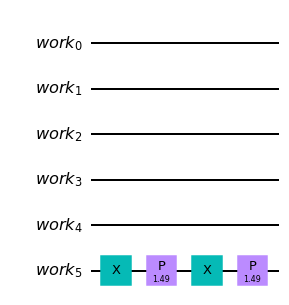

In [352]:
_H1 = H1(a,b,t,work_register,n_w)
_H1.draw(output='mpl')

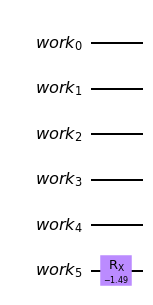

In [353]:
_H2 = H2(a,b,t,work_register,n_w)
_H2.draw(output='mpl')

<ipython-input-351-90c0e6a092f4>:50: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  H3_circuit = H3_circuit + _C


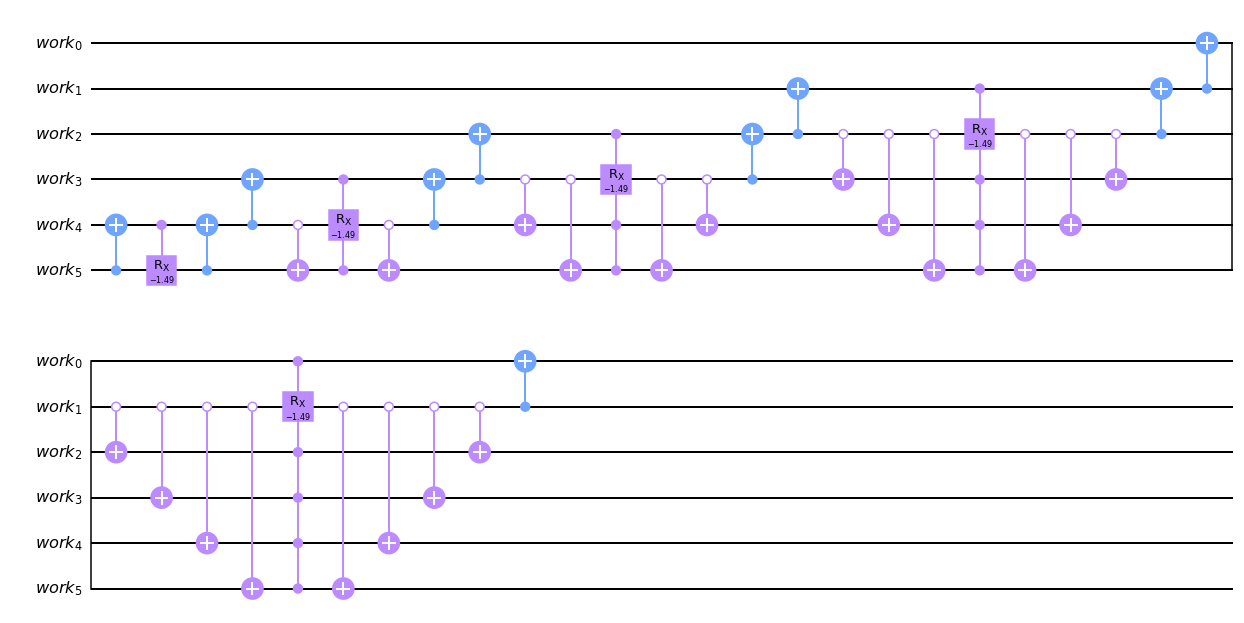

In [354]:
_H3 = H3(a,b,t,work_register,n_w)
_H3.draw(output='mpl')

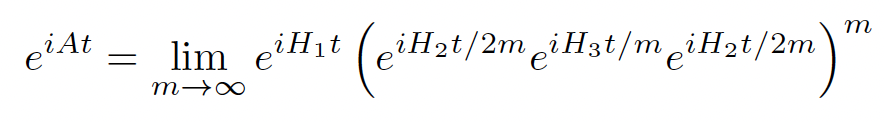
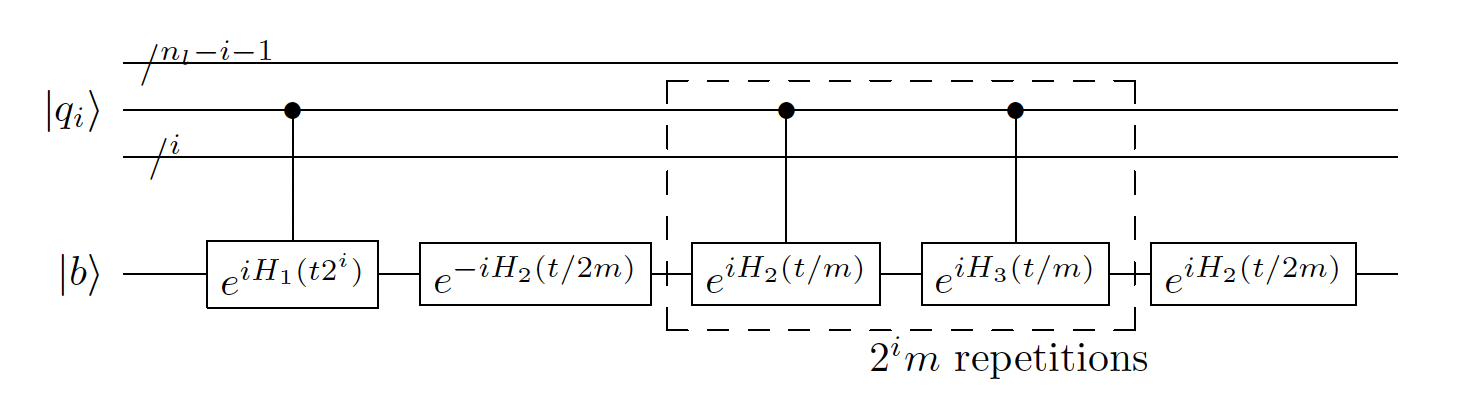

In [355]:
# Now we want to combine all the pieces together to make function that will return powers of U
# Basically we are going to repeat the circuit to apply the powers (H1 commutes so no need for that part)

def U_pow(a,b,t,work_register,n_w,m,i):
    U_pow_circuit = QuantumCircuit(work_register,name='U^{}'.format(2**i))
    U_pow_circuit = U_pow_circuit+H1(a,b,t*2**i,work_register,n_w)
    for _i in range((2**i)*m):
        #U_pow_circuit.barrier()
        U_pow_circuit=U_pow_circuit+H2(a,b,t/2/m,work_register,n_w)
        #U_pow_circuit.barrier()
        U_pow_circuit=U_pow_circuit+H3(a,b,t/m  ,work_register,n_w)
        #U_pow_circuit.barrier()
        U_pow_circuit=U_pow_circuit+H2(a,b,t/2/m,work_register,n_w)
        #U_pow_circuit.barrier()
    return U_pow_circuit.to_gate(label='U^{}'.format(2**i))
        

In [356]:
# Now we can start working with the clock registers and start applying controlled versions of this circuit
# to make the QPE gate

In [357]:
# Qiskit uses the little endian convention
# This means that the most significant bit is the lowest qubit
# and the least significant bit is the highest qubit

In [358]:
QPE_circuit = QuantumCircuit(clock_register,work_register,name='QPE')

In [359]:
QPE_circuit.h(clock_register)
    
for _i in range(n_l):
    # Get the appropriate gate for the power
    U_i = U_pow(a,b,t,work_register,n_w,m,_i)
    c_U_i = U_i.control(1)
    QPE_circuit.append(c_U_i,[clock_register[n_l-1-_i]] + [_x for _x in work_register])
    
from qiskit.circuit.library import QFT
QPE_circuit = QPE_circuit.compose(QFT(num_qubits=n_l, approximation_degree=0, do_swaps=True, inverse=True, insert_barriers=False, name='IQFT'),clock_register)
#QPE_circuit = QPE_circuit.compose(_myqft,qubits=clock_register)

<ipython-input-355-49436f4ddb6e>:6: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  U_pow_circuit = U_pow_circuit+H1(a,b,t*2**i,work_register,n_w)
<ipython-input-355-49436f4ddb6e>:9: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  U_pow_circuit=U_pow_circuit+H2(a,b,t/2/m,work_register,n_w)
<ipython-input-351-90c0e6a092f4>:50: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  H3_circuit = H3_circuit + _C
<ipython-input-355-49436f4ddb6e>:11: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  U_pow_circuit=U_pow_circuit+H3(a,b,t/m  ,work_

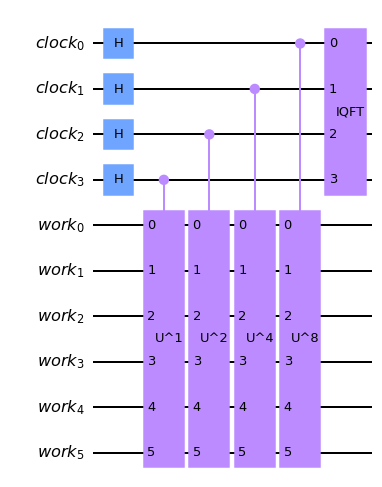

In [360]:
QPE_circuit.draw(output='mpl')

In [361]:
QPE = QPE_circuit.to_gate(label='QPE')

In [362]:
# Define the HHL circuit
# This will have the ancilla, clock, and work registers along with a classical register which will be used to
# measure the ancilla qubit until success

HHL_circuit = QuantumCircuit(ancilla,clock_register,work_register,name='HHL')

In [363]:
HHL_circuit = HHL_circuit+QPE_circuit

<ipython-input-363-8f7031a121f6>:1: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  HHL_circuit = HHL_circuit+QPE_circuit


In [364]:
HHL_circuit.draw()

controlled_rotation: ──────────────────────────────────────────────
                     ┌───┐                                ┌───────┐
            clock_0: ┤ H ├───────────────────────────■────┤0      ├
                     ├───┤                           │    │       │
            clock_1: ┤ H ├───────────────────■───────┼────┤1      ├
                     ├───┤                   │       │    │  IQFT │
            clock_2: ┤ H ├───────────■───────┼───────┼────┤2      ├
                     ├───┤           │       │       │    │       │
            clock_3: ┤ H ├───■───────┼───────┼───────┼────┤3      ├
                     └───┘┌──┴───┐┌──┴───┐┌──┴───┐┌──┴───┐└───────┘
             work_0: ─────┤0     ├┤0     ├┤0     ├┤0     ├─────────
                          │      ││      ││      ││      │         
             work_1: ─────┤1     ├┤1     ├┤1     ├┤1     ├─────────
                          │      ││      ││      ││      │         
             work_2: ─────┤2     ├┤2     ├┤2     ├┤2     ├─────────
                          │  U^1 ││  U^2 ││  U^4 ││  U^8 │         
             work_3: ─────┤3     ├┤3     ├┤3     ├┤3     ├─────────
                          │      ││      ││      ││      │         
             work_4: ─────┤4     ├┤4     ├┤4     ├┤4     ├─────────
                          │      ││      ││      ││      │         
             work_5: ─────┤5     ├┤5     ├┤5     ├┤5     ├─────────
                          └──────┘└──────┘└──────┘└──────┘

In [149]:
HHL_circuit.draw()

controlled_rotation: 
                     
            clock_0: 
                     
            clock_1: 
                     
            clock_2: 
                     
            clock_3: 
                     
             work_0: 
                     
             work_1: 
                     
             work_2: 
                     
             work_3: 
                     
             work_4: 
                     
             work_5: